Here we will try to generate ECG signals. We will use the WGAN.


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/'My Drive'/Internship/Project

Mounted at /content/gdrive/
/content/gdrive/My Drive/Internship/Project


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from pickle import load, dump

from tensorflow.keras.layers import  LeakyReLU, ReLU, PReLU, Activation, Dropout, BatchNormalization, Dense, \
                                  Input, Conv1D, MaxPool1D, AveragePooling1D, Flatten, LSTM, Reshape, Conv1DTranspose
from tensorflow.keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import Progbar
from tensorflow.keras.constraints import Constraint
import tensorflow as tf

In [ ]:
%run Code/Final/DataPreparation.ipynb

In [ ]:
%run Code/Final/Performance_metrics.ipynb

In [5]:
%run Code/Final/GANs.ipynb

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [7]:
# load data
train = np.loadtxt('Data/ECG5000_TRAIN.txt')
train = train.flatten()
train = train.reshape((-1,500,1))

*Try limeGAN*

In [8]:
freq_train = signal_2_fourier(train)

In [13]:
freqgan = limeGAN(kernel=5, gen_layers=4, dis_layers=4, latentDim=200, depth=20, dil=1, snippet_len=500, 
                  channels=1, dropout=0.3, INIT_LR=1e-5, DECAY=6e-8)

In [14]:
freqgan.train(freq_train, epochs=250, batch_size=32, smoothen_labels=0, savepath='GANs/ecgGANfreq/')

3/4 [=====================>........] - ETA: 27s  EPOCH 249: [D loss: 0.502232, acc: 0.656250]   [A loss: 0.952878, acc: 0.187500]


In [15]:
fake = freqgan.generate_fake_signals(10)

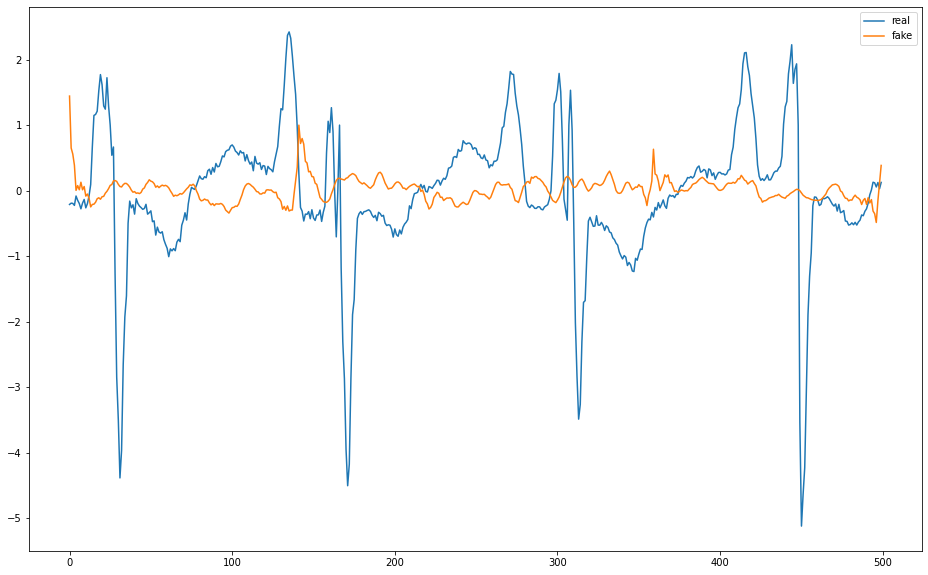

In [16]:
plt.figure(figsize=(16,10))
id = 7
plt.plot(np.arange(500), train[id,:,0], label='real')
plt.plot(np.arange(500), fake[id,:, 0], label='fake') 
plt.legend()
plt.show()

*WGAN*

In [47]:
wgan = WGAN(kernel=7, gen_layers=4, dis_layers=4, latentDim=200, depth=20, dil=1, snippet_len=500, 
            channels=1, dropout=0.3, savepath='GANs/WGANecg1/')

In [48]:
wgan.train(train, epochs=250, batch_size=32, n_critic=3)

3/4 [=====================>........] - ETA: 55s  EPOCH 249: [D loss: 544461.375000, acc: 0.500000]   [A loss: -642807.000000, acc: 0.000000]


In [53]:
wfake = wgan.generate_fake_signals(10)

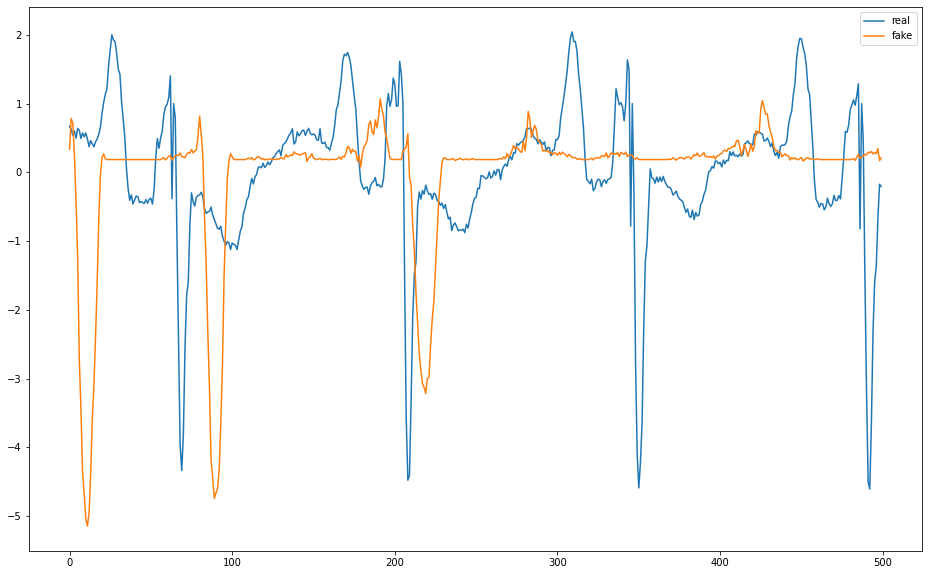

In [55]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(500), train[1,:,0], label='real')
plt.plot(np.arange(500), wfake[4,:,0], label='fake') 
plt.legend()
plt.show()

In [52]:
# wgan.save('wgan_ecg')
# wgan = WGAN.load('Models/Final/wgan_ecg')

*anoGAN*

In [ ]:
anogan = ANOGAN(wgan)

In [ ]:
# DO NOT DELETE, THIS IS MY EXAMPLE
s = 1000000
data =   np.sin(np.arange(0, s, 0.1)) * np.cos(np.arange(0, s, 0.1)) + np.random.normal(0, 1, size=len(np.arange(0, s, 0.1))) #
data = np.reshape(data, newshape=(-1, 500, 1))
# data_freq = signal_2_fourier(data)

In [ ]:
y_lik_normal = anogan.anomaly_scores(train[0:50])

In [ ]:
y_lik_anom = anogan.anomaly_scores(data[0:50])
y_lik = np.concatenate((y_lik_anom, y_lik_normal))
y_true = np.ones(100)
y_true[50:] = 0

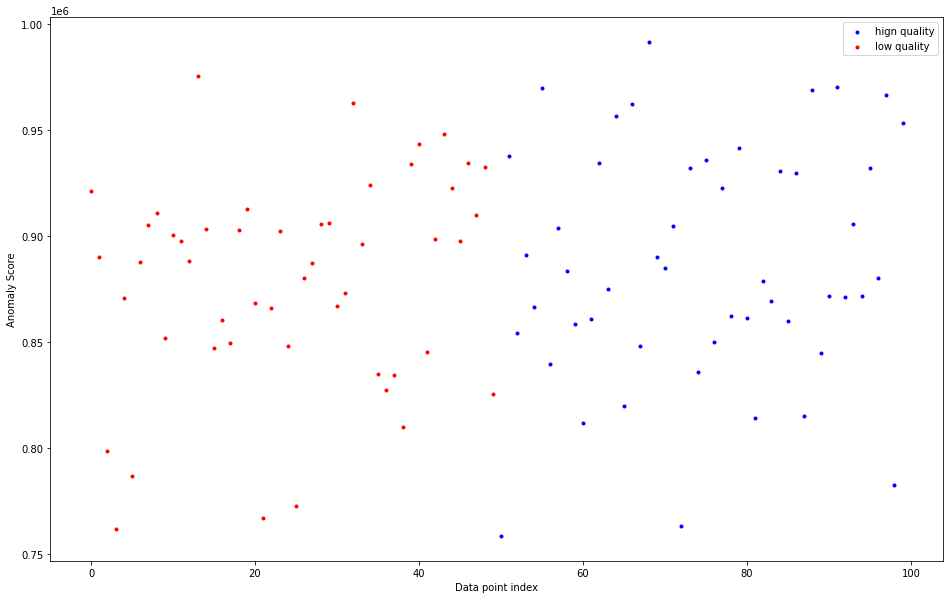

In [ ]:
scatter_GANs(y_true,y_lik)